In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from itertools import accumulate
import cvxpy as cp

torch.manual_seed(1)

/Users/scortesg/opt/anaconda3/envs/rp_fall2022/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset construction

In [2]:
data = pd.read_csv("german_credit_data.csv", index_col=0)
data_labels = pd.read_csv("german_credit.csv")
data_dummies = pd.get_dummies(data["Sex"])
data_dummies[["free", "own", "rent"]] = pd.get_dummies(data["Housing"])
data_dummies[["little", "moderate", "quite rich", "rich"]] = pd.get_dummies(data["Saving accounts"])
data_dummies[["Age Bucket A", "Age Bucket B", "Age Bucket c", "Age Bucket D"]] = pd.get_dummies(pd.cut(data.Age, [18, 25, 45, 60, 75]))
data_dummies["Creditability"] = data_labels["Creditability"]

var = data_dummies.columns
VAR = var[:-1]
VAR

Index(['female', 'male', 'free', 'own', 'rent', 'little', 'moderate',
       'quite rich', 'rich', 'Age Bucket A', 'Age Bucket B', 'Age Bucket c',
       'Age Bucket D'],
      dtype='object')

## Fit unbiased coefficients

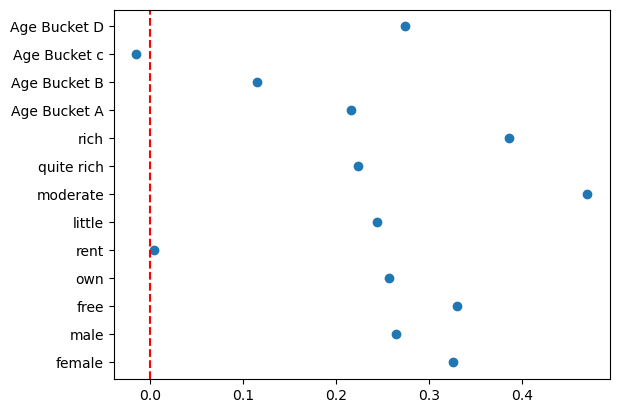

In [3]:
logit = sm.GLM(data_dummies["Creditability"], data_dummies[VAR].to_numpy(), family=sm.families.Binomial())
results = logit.fit()
coef = results.params
results.summary()

x = list(range(len(VAR)))
plt.scatter(coef, x)
plt.yticks(x, VAR)
plt.axvline(x=0, color="r", linestyle="--")
plt.show()

## Construct biased dataset

In [4]:
females = data_dummies[data_dummies.female == 1]
females_good = females[females.Creditability == 1]
females_bad = females[females.Creditability == 0]
males = data_dummies[data_dummies.female == 0]
males_good = males[males.Creditability == 1]
males_bad = males[males.Creditability == 0]
ma_good_sample = males_good.sample(frac = 0.25)
fem_bad_sample = females_bad.sample(frac = 0.25)
sex_skewed_data = pd.concat([ma_good_sample, males_bad, females_good, fem_bad_sample])

In [5]:
#Build more restrictions
# Those it make anys ense to build this in Pythorch? It is a good thing to think about?
# The ERM is irreevant, Nothing is goign to come out of there becase the very bests et of weights was already fitted?


In [6]:
ONE = torch.tensor([1.])
def assign_weights(row, label, w):
    if label == 0:
        if row[0] == 1:
            if row[7] == 1:
                return 1/(0.25 - w[0])
            else:
                return 1/w[0]
        else:
            return ONE
    if label ==1:
        if row[1] == 0:
            return ONE 
        else:
            if row[7] == 1:
                return 1/(0.25 - w[1])
            else:
                return 1/w[1]

In [22]:
NUM_FEATURES = len(VAR)
NUM_LABELS = 1


class WeightedLogisticRegression(nn.Module):  # inheriting from nn.Module!

    def __init__(self, num_features, num_labels):
        super(WeightedLogisticRegression, self).__init__()
        self.linear = torch.tensor(coef, requires_grad=False)
        self.sigmoid = nn.Sigmoid()
        weights = torch.rand(2, 1, requires_grad=True)
        self.weights = torch.nn.parameter.Parameter(weights, requires_grad=True)

    def forward(self, features):
        features = torch.dot(self.linear, self.linear)
        return self.sigmoid(features)


model = WeightedLogisticRegression(NUM_FEATURES, NUM_LABELS)

for param in model.parameters():
    print(param)

print("====================================")
data = sex_skewed_data[VAR].to_numpy()
labels = sex_skewed_data["Creditability"]

#with torch.no_grad():
#    print("features:", data[0])
#    sample = torch.tensor(data[0]).float()
#    log_probs = model(sample)
#    print("log rpobs:", log_probs)

Parameter containing:
tensor([[0.0293],
        [0.7999]], requires_grad=True)


In [24]:
# Loss function and optimize
loss_function = torch.nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Usually you want to pass over the training data several times.
# 100 is much bigger than on a real data set, but real datasets have more than
# two instances.  Usually, somewhere between 5 and 30 epochs is reasonable.
for epoch in range(10):
    for instance, label in zip(data, labels):
        # Step 1. Remember that PyTorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2.
        features = torch.tensor(instance.astype(np.double)).float()
        # Step 3. Run our forward pass.
        weight = assign_weights(features, label, model.weights)
       
        with torch.no_grad():            
                weight.clamp_(0)
                weight.clamp_(None, 0.25)
        probs = model(features) * weight
        
        with torch.no_grad():            
                probs.clamp_(None, 1)
        target = torch.tensor(label, dtype = torch.long).expand((1)).float()
        
        # Step 4. Compute the loss, gradients, and update the parameters by
        
        # print(model.linear)
        loss = loss_function(probs, target)
        #print(loss)
        #print("Loss", loss)
        #print(model.weights)
        if loss.requires_grad:
            loss.backward(create_graph=True)
            optimizer.step()

with torch.no_grad():
     print(model.weights)
#    for instance, label in test_data:
#        bow_vec = make_bow_vector(instance, word_to_ix)
#        log_probs = model(bow_vec)
#        print(log_probs)

# print(next(model.parameters()))

Parameter containing:
tensor([[1.3303e+00],
        [2.5071e+09]], requires_grad=True)


In [20]:
sex_skewed_data.columns

Index(['female', 'male', 'free', 'own', 'rent', 'little', 'moderate',
       'quite rich', 'rich', 'Age Bucket A', 'Age Bucket B', 'Age Bucket c',
       'Age Bucket D', 'Creditability'],
      dtype='object')

In [21]:
NUM_FEATURES = len(VAR)
NUM_LABELS = 1



class WeightedLogisticRegression(nn.Module):  # inheriting from nn.Module!

    def __init__(self, num_features, num_labels):
        super(WeightedLogisticRegression, self).__init__()
        
        
        self.linear = torch.nn.Linear(in_features=13, out_features=1, bias=True)
        self.sigmoid = nn.Sigmoid()
        weights = torch.rand(2, 1, requires_grad=False)
        self.weights = torch.nn.parameter.Parameter(weights, requires_grad=True)
    def forward(self, features):
        features = self.linear(features)
        return self.sigmoid(features)


model = WeightedLogisticRegression(NUM_FEATURES, NUM_LABELS)

for param in model.parameters():
    print(param)

print("====================================")
data = sex_skewed_data[VAR].to_numpy()
labels = sex_skewed_data["Creditability"]

#with torch.no_grad():
#    print("features:", data[0])
#    sample = torch.tensor(data[0]).float()
#    log_probs = model(sample)
#    print("log rpobs:", log_probs)

Parameter containing:
tensor([[0.4194],
        [0.3743]], requires_grad=True)
Parameter containing:
tensor([[-0.1178,  0.0038, -0.1585, -0.1547, -0.0414, -0.0799,  0.0681, -0.0729,
         -0.0368, -0.1059, -0.2535,  0.2419,  0.0529]], requires_grad=True)
Parameter containing:
tensor([0.2480], requires_grad=True)


In [36]:
model.weights

Parameter containing:
tensor([[0.4194],
        [0.3743]])

In [39]:
for beta in model.linear.parameters():
    print(beta[0][0])

tensor(0.8459, grad_fn=<SelectBackward0>)


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [42]:
# Loss function and optimize
loss_function = torch.nn.BCELoss()
second_loss_function = torch.nn.MSELoss()
optimizer = optim.SGD(params=model.linear.parameters(), lr=0.001)
optimizer_2 = torch.optim.Adam(params=[model.weights], lr=0.001)

for i in range(20):
    
    
    for epoch in range(10):
        for instance, label in zip(data, labels):
            # Step 1. Remember that PyTorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2.
            features = torch.tensor(instance.astype(np.double)).float()
            # Step 3. Run our forward pass.
            weight = assign_weights(features, label, model.weights)

            with torch.no_grad():            
                    weight.clamp_(0)
                    weight.clamp_(None, 0.25)
            probs = model(features) * weight

            with torch.no_grad():            
                    probs.clamp_(None, 1)
            target = torch.tensor(label, dtype = torch.long).expand((1)).float()

            # Step 4. Compute the loss, gradients, and update the parameters by
            loss = loss_function(probs, target)


            if loss.requires_grad:
                loss.backward(create_graph=True)
                optimizer.step()

    # Put an assert ensuring the betas have 0 gradients.
    coeff = next(model.linear.parameters())
    loss_w = second_loss_function(coeff[0][0], torch.tensor([0.]))
    print(loss)
    loss_w.backward()
    

/Users/scortesg/opt/anaconda3/envs/rp_fall2022/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.2824, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2830, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2835, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2839, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2842, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2845, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2848, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2850, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2851, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2853, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2854, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2856, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2857, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2858, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2859, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2860, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2860, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2861, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2862, grad_fn=<Bina

KeyboardInterrupt: 

In [43]:
# Loss function and optimize
loss_function = torch.nn.BCELoss()
second_loss_function = torch.nn.MSELoss()
optimizer = optim.SGD(params=model.linear.parameters(), lr=0.001)
optimizer_2 = torch.optim.Adam(params=[model.weights], lr=0.001)

for i in range(20):
    
    
    for epoch in range(10):
        for instance, label in zip(data, labels):
            # Step 1. Remember that PyTorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2.
            features = torch.tensor(instance.astype(np.double)).float()
            # Step 3. Run our forward pass.
            weight = assign_weights(features, label, model.weights)

            with torch.no_grad():            
                    weight.clamp_(0)
                    weight.clamp_(None, 0.25)
            probs = model(features) * weight

            with torch.no_grad():            
                    probs.clamp_(None, 1)
            target = torch.tensor(label, dtype = torch.long).expand((1)).float()

            # Step 4. Compute the loss, gradients, and update the parameters by
            loss = loss_function(probs, target)


            if loss.requires_grad:
                loss.backward(create_graph=True)
                optimizer.step()

    # Put an assert ensuring the betas have 0 gradients.
    coeff = next(model.linear.parameters())
    loss_w = -second_loss_function(coeff[0][0], torch.tensor([0.]))
    print(loss)
    loss_w.backward()

tensor(0.2863, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2863, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2864, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2864, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2865, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2865, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2865, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2866, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2866, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2866, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2867, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2867, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2867, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2868, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2868, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2868, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2868, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2868, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2869, grad_fn=<Bina

Parameter containing:
tensor([[1.3303e+00],
        [2.5071e+09]], requires_grad=True)


ValueError: x and y must be the same size

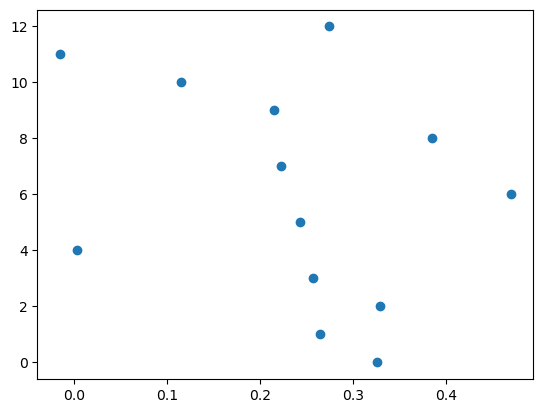

In [25]:
for param in model.parameters():
    print(param)

with torch.no_grad():
    coef_bias = next(model.parameters())[0]
    x = list(range(len(VAR)))
    plt.scatter(coef, x)
    plt.scatter(coef_bias, x)
    plt.legend(["original", "biased"])
    plt.yticks(x, VAR)
    plt.axvline(x=0, color="r", linestyle="--")
    plt.show()

In [62]:
true_prop_good_fem = females_good.female.sum()
true_prop_bad_fem = females_bad.female.sum()
obs_prop_good_fem = sex_skewed_data[sex_skewed_data["Creditability"] == 1].female.sum()
obs_prop_bad_fem = sex_skewed_data[sex_skewed_data["Creditability"] == 0].female.sum()

true_prop_good_m = males_good.male.sum()
true_prop_bad_m = males_bad.male.sum()
obs_prop_good_m = sex_skewed_data[sex_skewed_data["Creditability"] == 1].male.sum()
obs_prop_bad_m = sex_skewed_data[sex_skewed_data["Creditability"] == 0].male.sum()

print(true_prop_good_fem, true_prop_bad_fem, obs_prop_good_fem, obs_prop_bad_fem)
print(true_prop_good_m, true_prop_bad_m, obs_prop_good_m, obs_prop_bad_m)

w = np.array([obs_prop_good_fem/true_prop_good_fem, 1])
w_b = np.array([obs_prop_bad_fem/true_prop_bad_fem, 1])
print(w, w_b)
w_M = np.array([obs_prop_good_m/true_prop_good_m, 1])
w_Mb = np.array([obs_prop_bad_m/true_prop_bad_m, 1])
print(w_M, w_Mb)

219 91 219 23
481 209 120 209
[1. 1.] [0.25274725 1.        ]
[0.24948025 1.        ] [1. 1.]


In [63]:
search_space_x = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25]
search_space_y = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.24]

0.22304520605008724


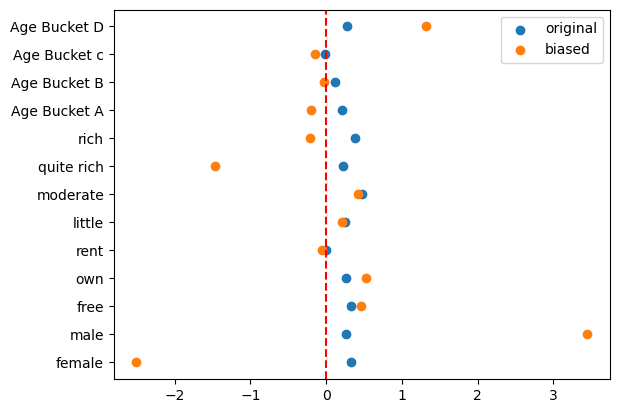

0.22304520605008724


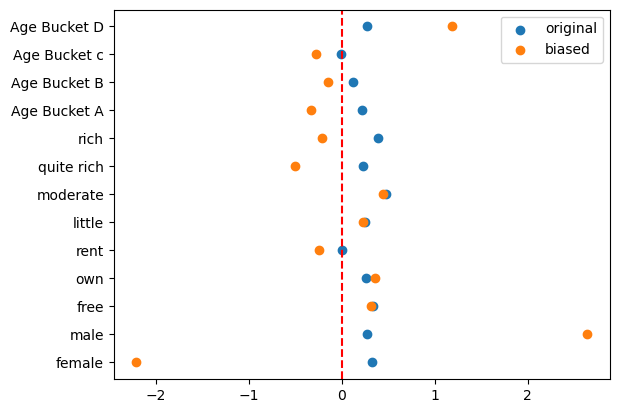

0.22304520605008724


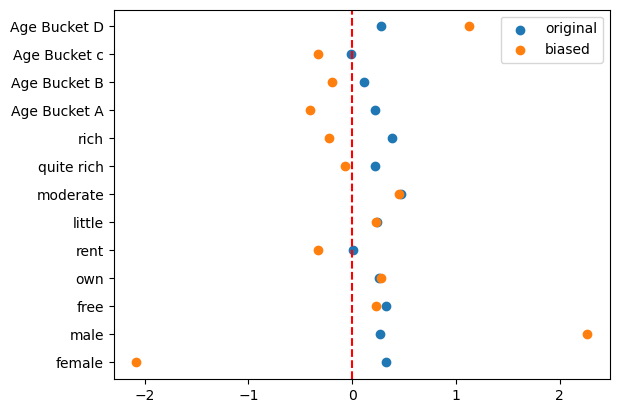

0.22304520605008724


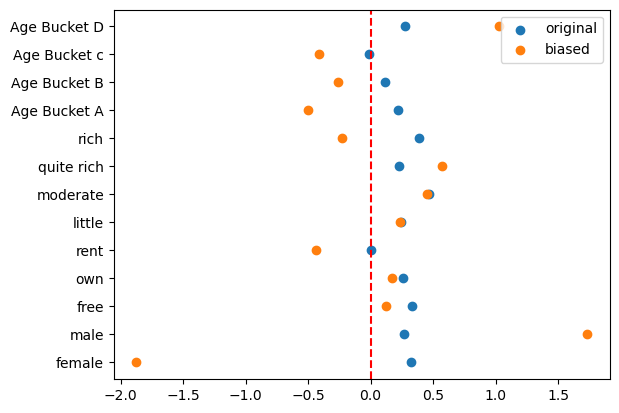

0.22304520605008724


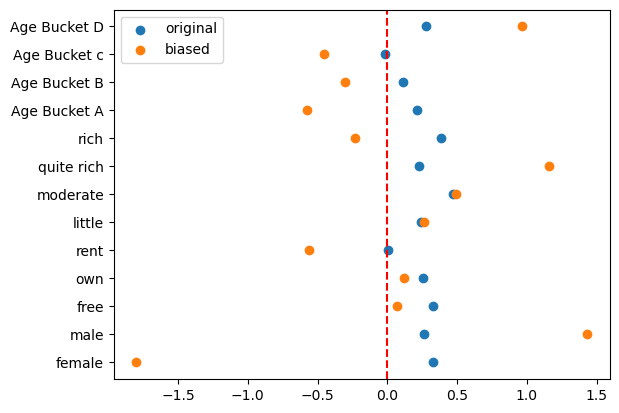

0.22304520605008724


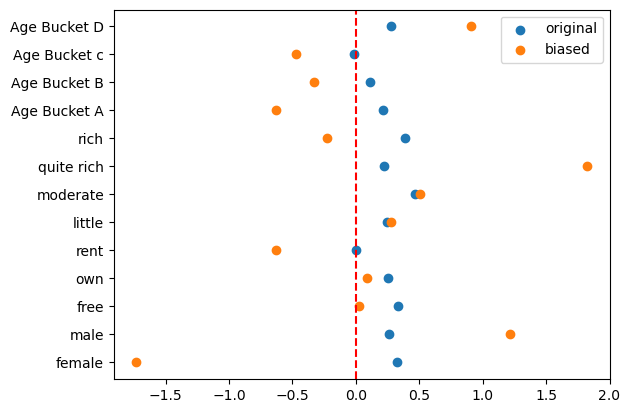

0.22304520605008724


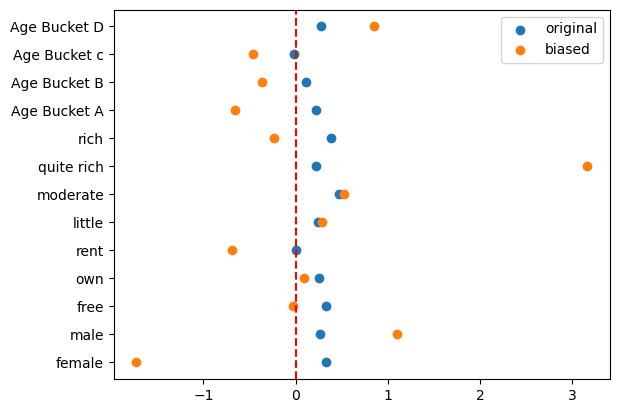

0.22304520605008724


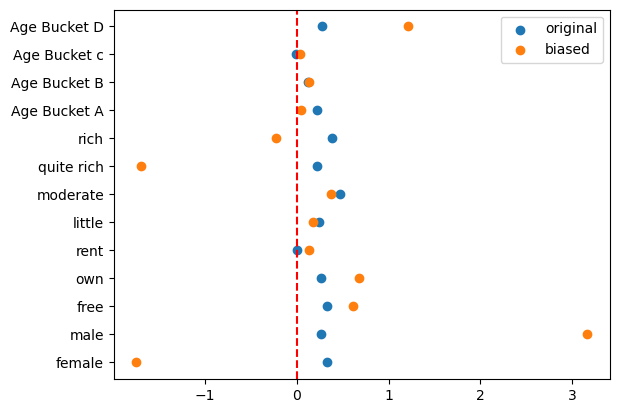

0.22304520605008724


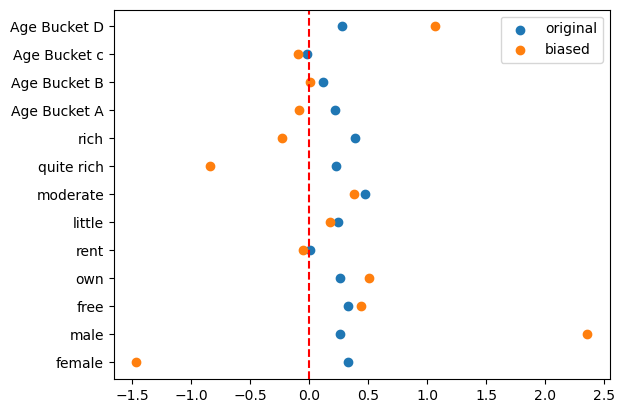

0.22304520605008724


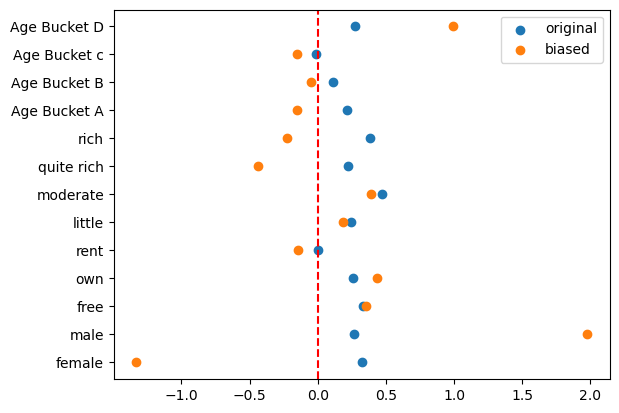

0.22304520605008724


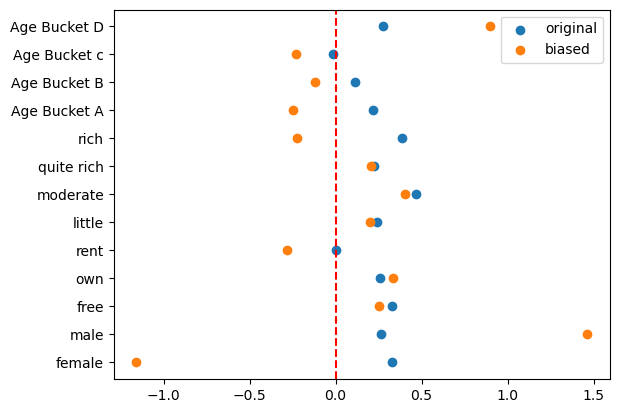

0.22304520605008724


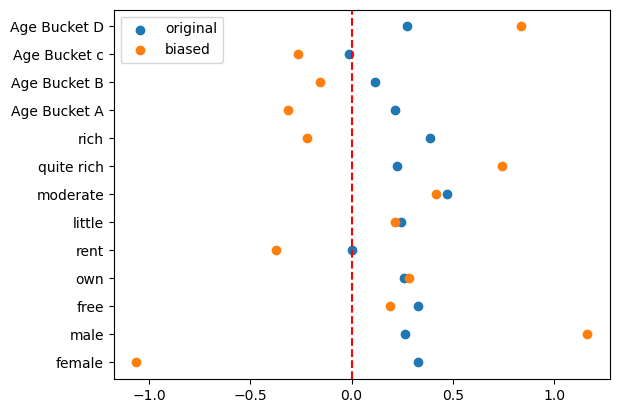

0.22304520605008724


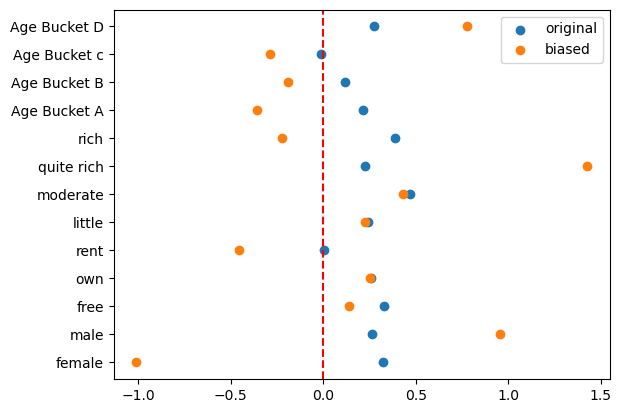

0.22304520605008724


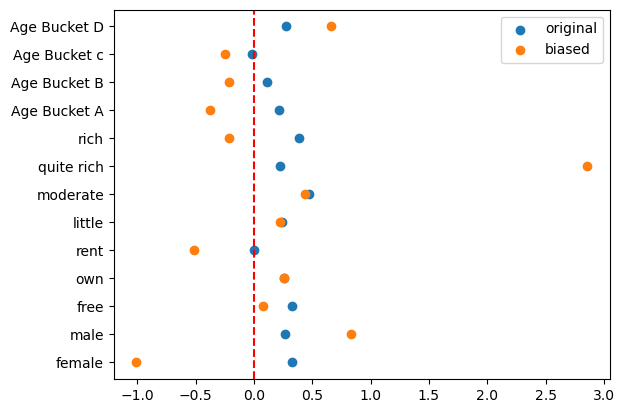

0.22304520605008724


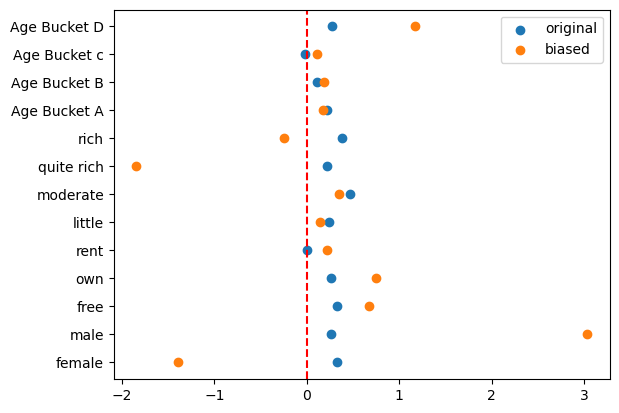

0.22304520605008724


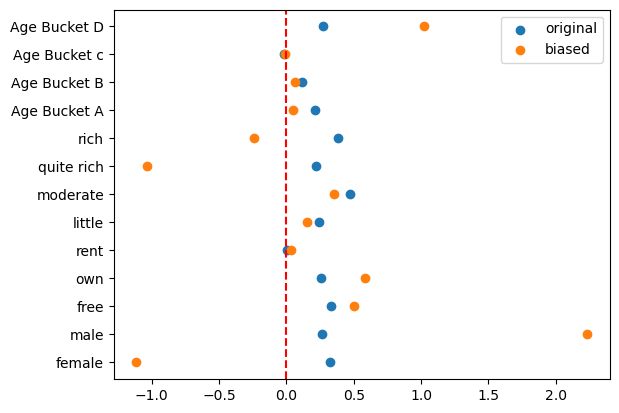

0.22304520605008724


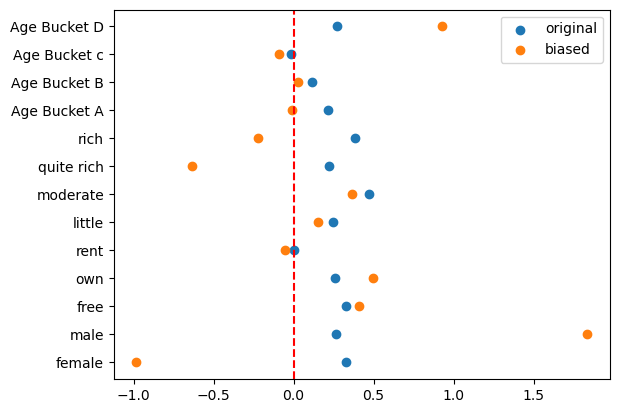

0.22304520605008724


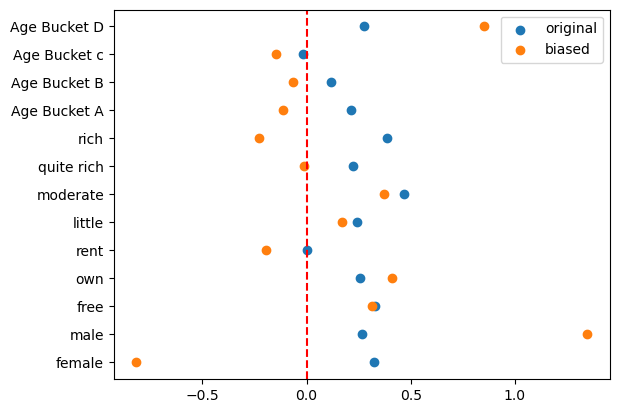

0.22304520605008724


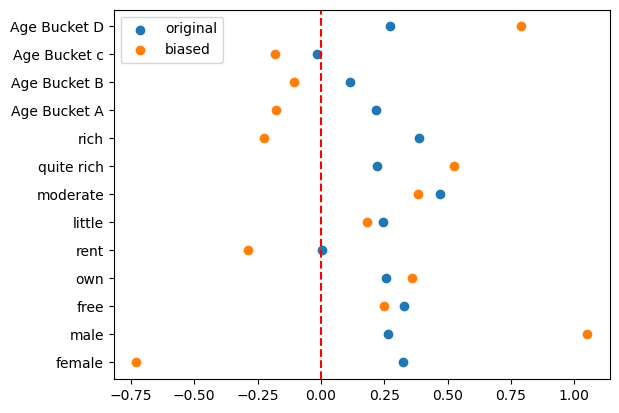

0.22304520605008724


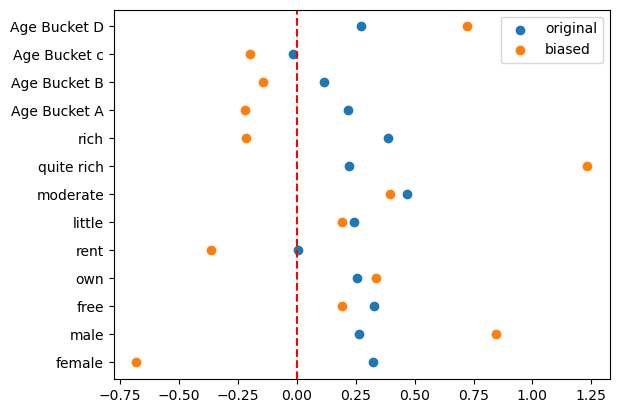

0.22304520605008724


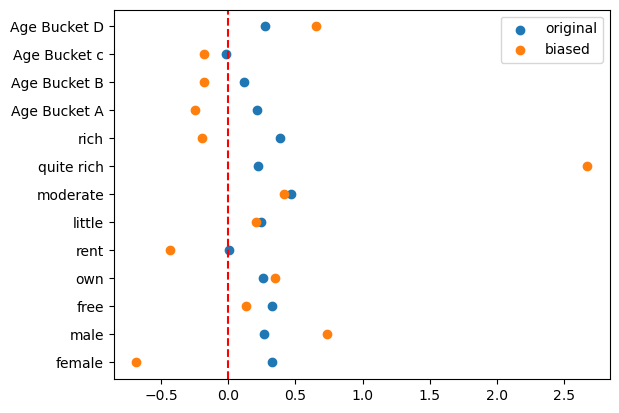

0.22304520605008724


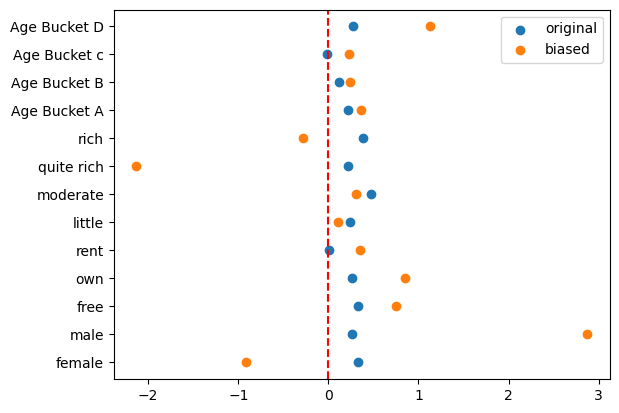

0.22304520605008724


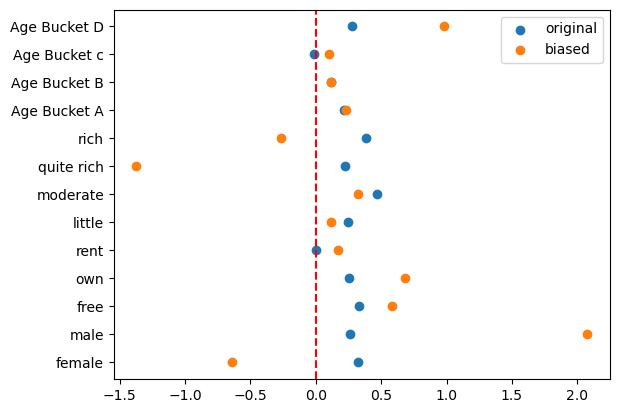

0.22304520605008724


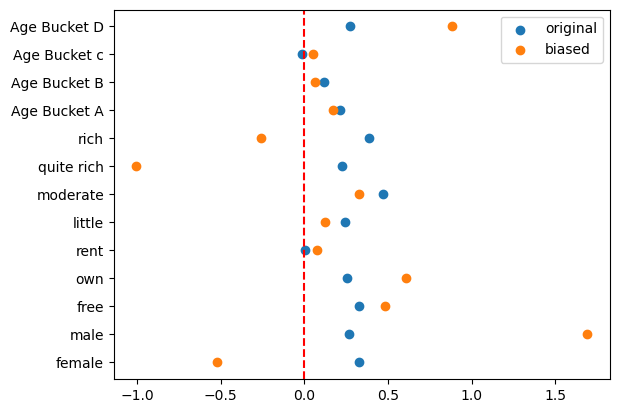

0.22304520605008724


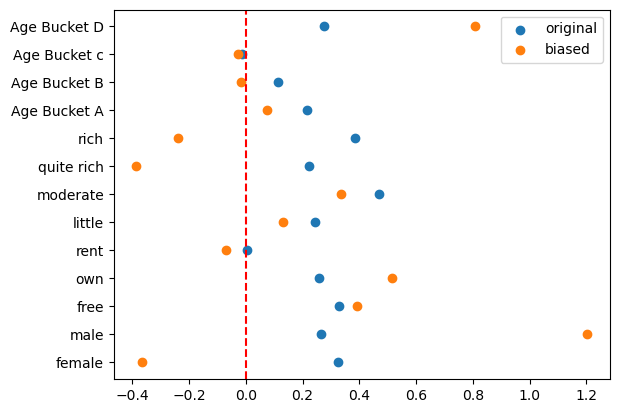

0.22304520605008724


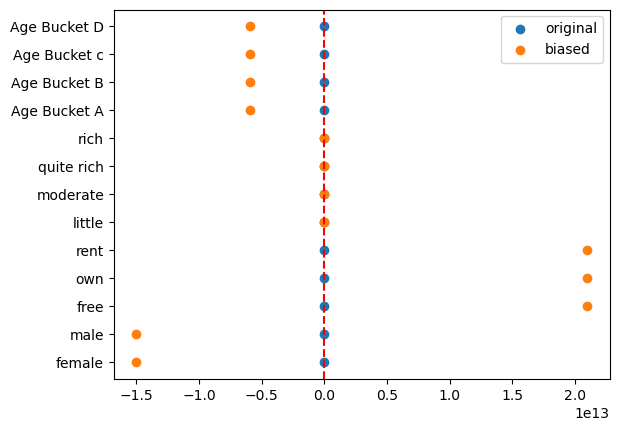

0.22304520605008724


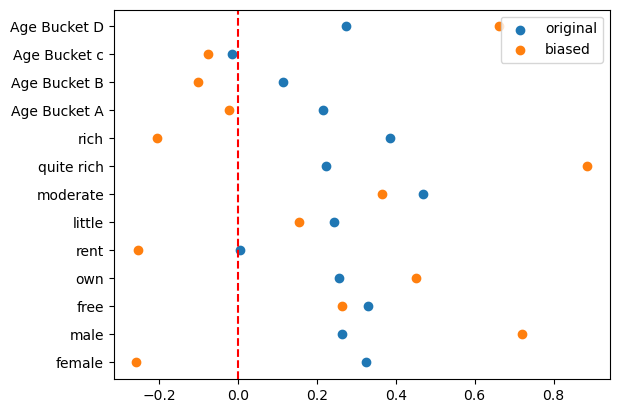

0.22304520605008724


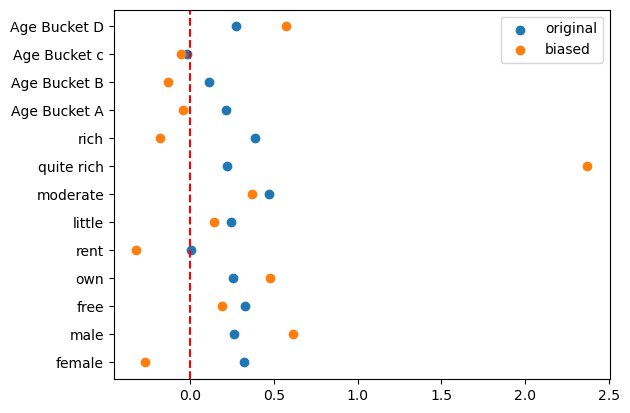

0.22304520605008724


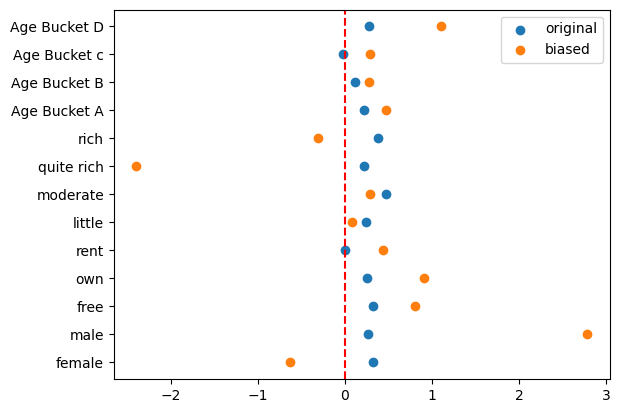

0.22304520605008724


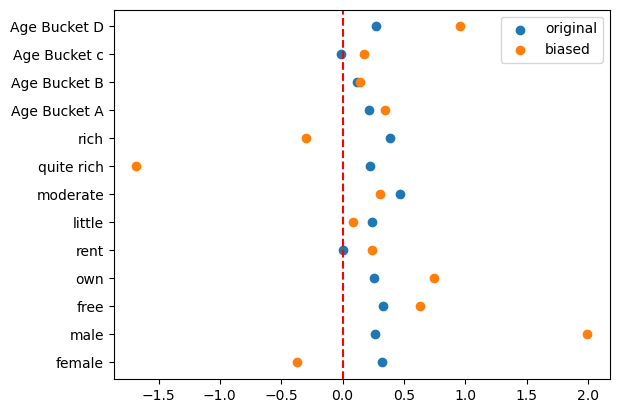

0.22304520605008724


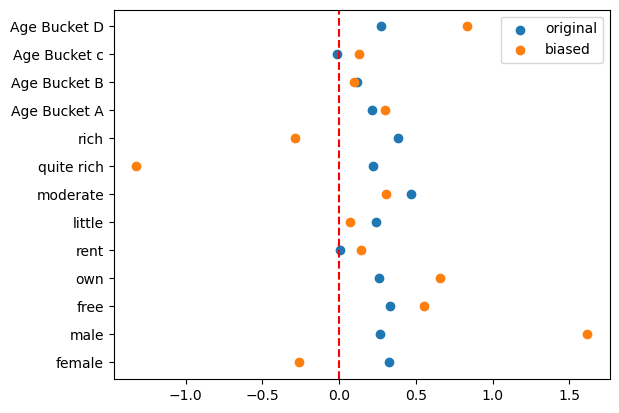

0.22304520605008724


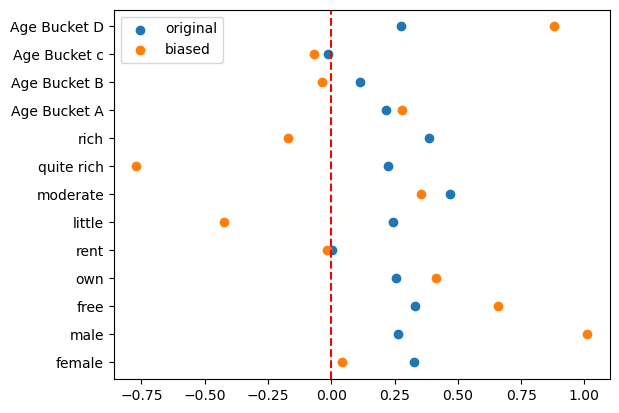

0.22304520605008724


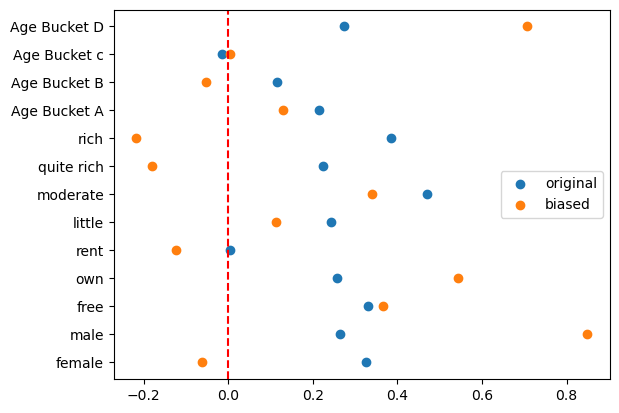

0.22304520605008724


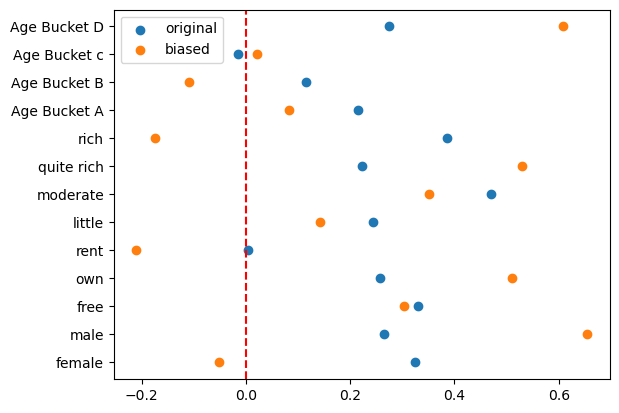

0.22304520605008724


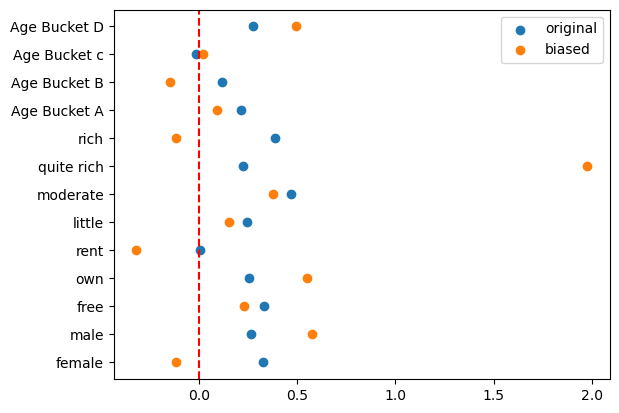

0.22304520605008724


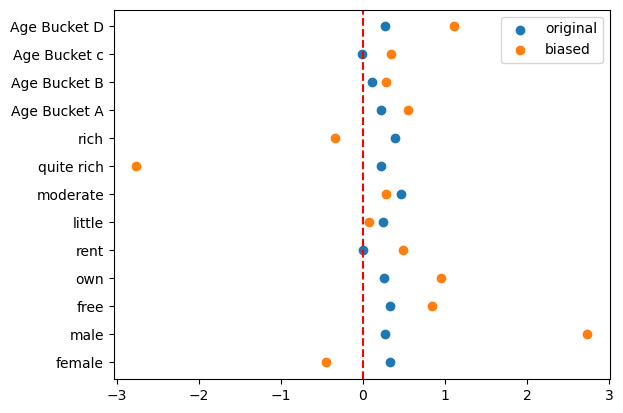

0.22304520605008724


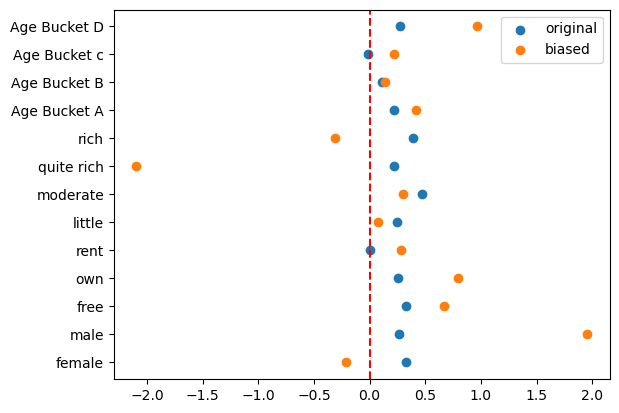

0.22304520605008724


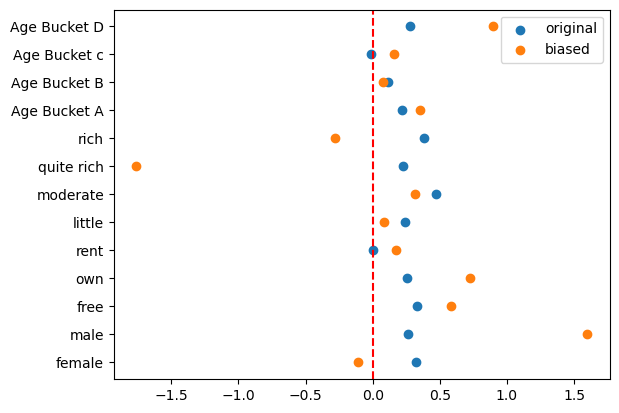

0.22304520605008724


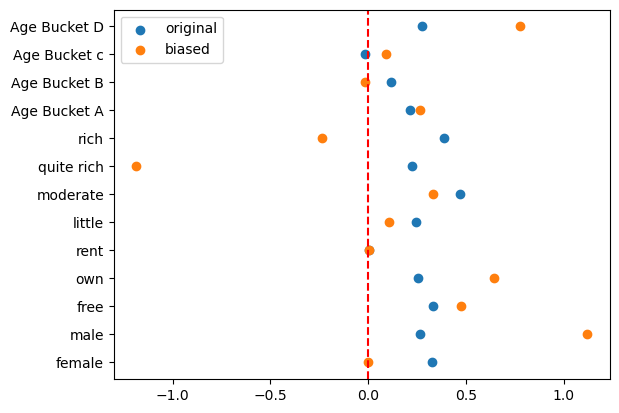

0.22304520605008724


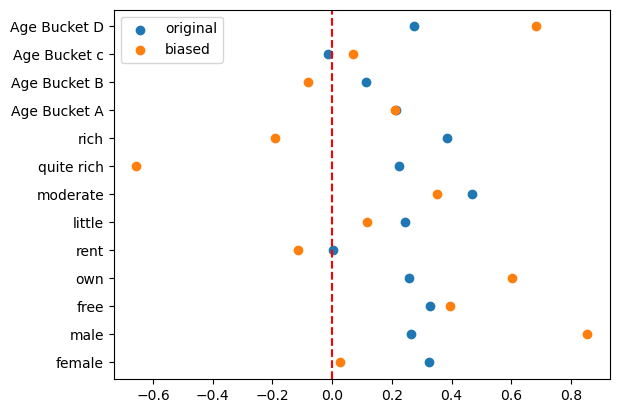

0.22304520605008724


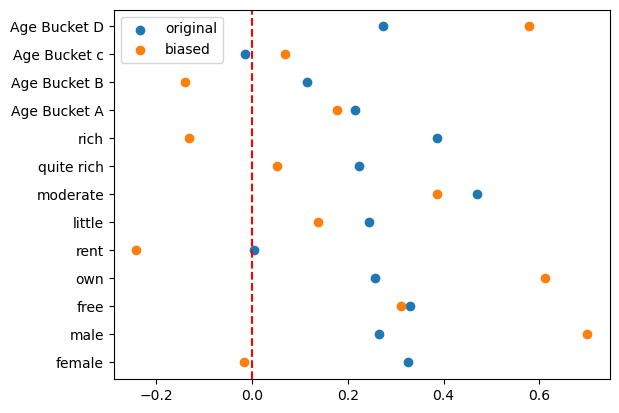

0.22304520605008724


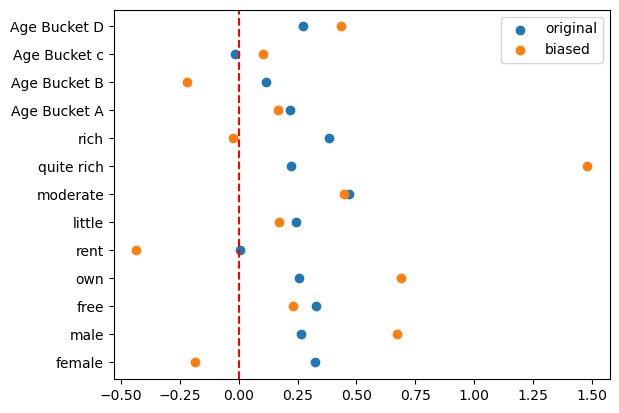

0.22304520605008724


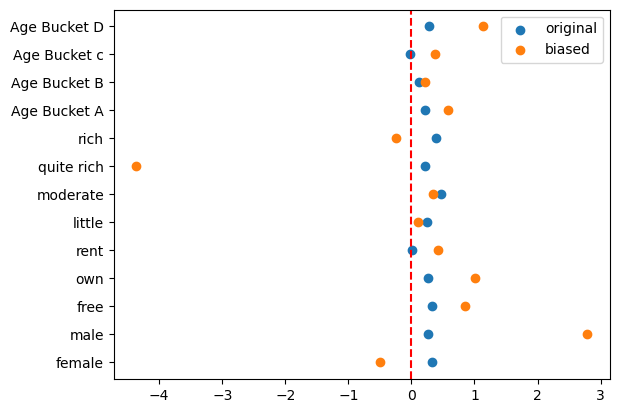

0.22304520605008724


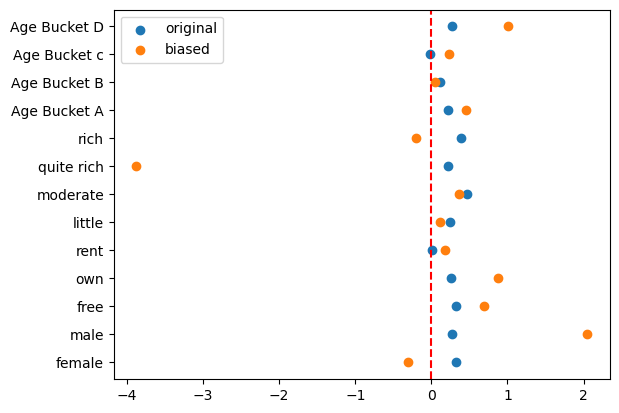

0.22304520605008724


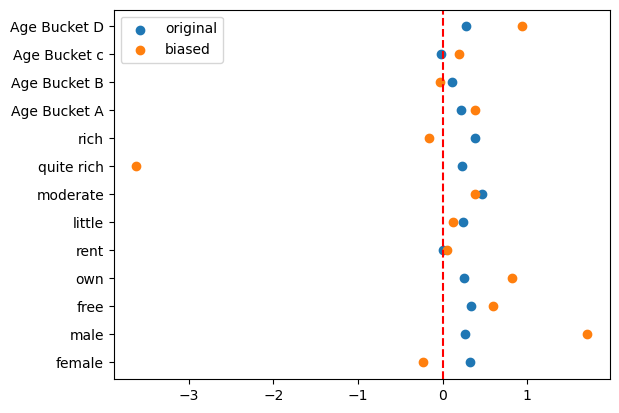

0.22304520605008724


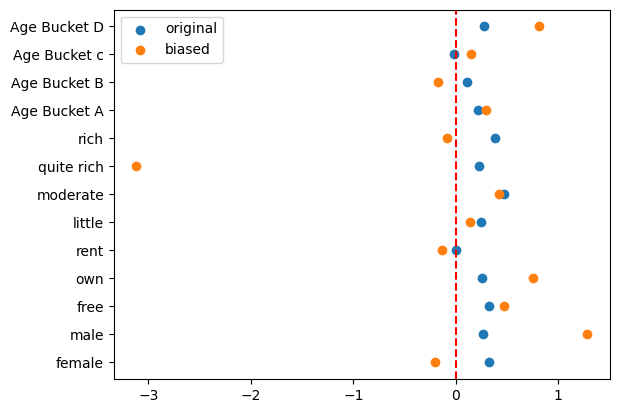

/Users/scortesg/opt/anaconda3/envs/rp_fall2022/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


0.22304520605008724


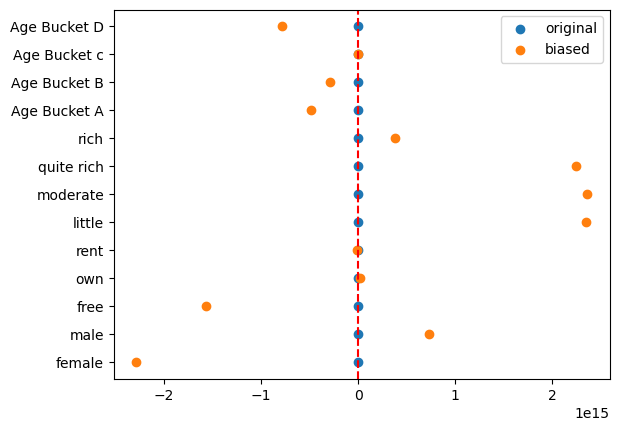

0.22304520605008724


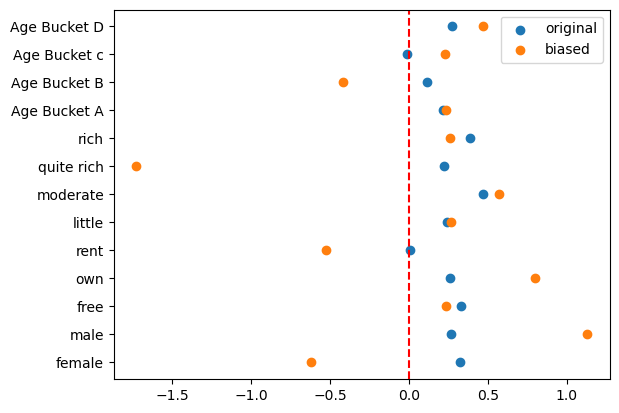

0.22304520605008724


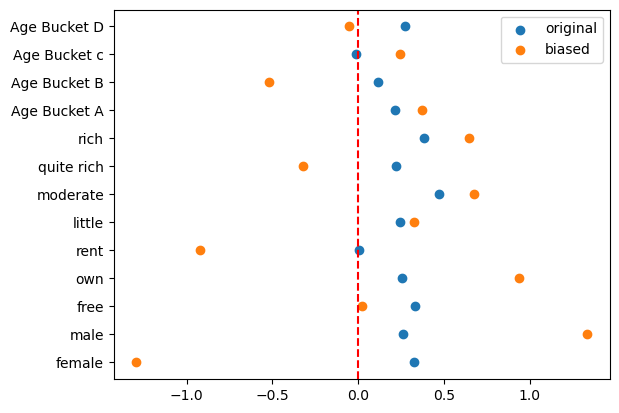

In [64]:
for weight_f in search_space_x:
    for weight_m in search_space_y:
        def assign_weights(row):
            if row.Creditability == 0:
                if row.female == 1:
                    if row["quite rich"] == 1:
                        return 1/(w_b[0] - weight_f)
                    else:
                        return 1/weight_f
                else:
                    return 1.
            if row.Creditability ==1:
                if row.male == 0:
                    return 1. 
                else:
                    if row["quite rich"] == 1:
                        return 1/(w_M[0] - weight_m)
                    else:
                        return 1/weight_m

        sex_skewed_data["weights"] = sex_skewed_data.apply(assign_weights, axis=1)
        logit = sm.GLM(sex_skewed_data["Creditability"], sex_skewed_data[VAR].to_numpy(), family=sm.families.Binomial(), var_weights=sex_skewed_data["weights"])
        results = logit.fit()
        coef_bias = results.params
        print(coef[7])
        x = list(range(len(VAR)))
        plt.scatter(coef, x)
        plt.scatter(coef_bias, x)
        plt.legend(["original", "biased"])
        plt.yticks(x, VAR)
        plt.axvline(x=0, color="r", linestyle="--")
        plt.show()

In [66]:
logit = sm.GLM(sex_skewed_data["Creditability"], sex_skewed_data[VAR].to_numpy(), family=sm.families.Binomial())
results = logit.fit()
coef_bias = results.params
print(coef[7])

0.22304520605008724


In [73]:
predictions = logit.predict(coef_bias)

In [87]:
B = np.zeros((2, 2))
B[0,0] = 1
B[1,1] = -1
B @ np.array([1,1])

array([ 1., -1.])

In [90]:
import cvxpy as cp
import numpy as np

# Problem data.
n = 2
np.random.seed(1)
B = np.zeros((2, 2))
B[0,0] = 1
B[1,1] = 1
b = np.array([0.25, 0.25]) 

# Construct the problem.
w = cp.Variable(n)

def assign_weights(row):
    if row.Creditability == 0:
        if row.female == 1:
            if row["quite rich"] == 1:
                return cp.inv_pos(0.25 - w[0])
            else:
                return cp.inv_pos(w[0])
        else:
            return 1.
    if row.Creditability ==1:
        if row.male == 0:
            return 1. 
        else:
            if row["quite rich"] == 1:
                return cp.inv_pos(0.25 - w[1])
            else:
                return cp.inv_pos(w[1])
            
A = sex_skewed_data.apply(assign_weights, axis=1)

objective = cp.Minimize(A @ predictions)

constraints = [0 <= w, B @ w == b]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
prob.solve()
# The optimal value for x is stored in `x.value`.

# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print("\nThe optimal value is", prob.value)
print("The optimal w is")
print(w)

NameError: name 'predictions' is not defined

In [54]:
"""
  0.325224
x2     0.264426
x3     0.329175
x4     0.256619
x5     0.003856
x6     0.243305
x7     0.469528
x8     0.223045
x9     0.385162
x10    0.215479
x11    0.114976
x12   -0.014848
x13    0.274042
"""
coef = np.array([0.325224, 0.264426, 0.329175, 0.256619, 0.003856, 0.243305,
                 0.469528, 0.223045, 0.385162, 0.215479, 0.114976, -0.014848, 0.274042])